## Double Deep Q-Network (DQN)
---
In this notebook, you will implement a DDQN agent with OpenAI Gym's LunarLander-v2 environment.

### Import the Necessary Packages

In [8]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

### Instantiate the Environment and Agent

Initialize the environment.

In [9]:
!pip install setuptools==65.5.0 pip==21

In [ ]:
!pip install gym[box2d]

     |████████████████████████████████| 374 kB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 10.4 MB/s 
     |████████████████████████████████| 18.3 MB 470 kB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [10]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


## Double DQN

In [11]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple

# Hyperparameters
BUFFER_SIZE = int(1e5)       # Replay buffer size
BATCH_SIZE = 64              # Minibatch size
GAMMA = 0.99                 # Discount factor
TAU = 1e-3                   # Soft update of target parameters
LR = 5e-4                    # Learning rate
UPDATE_EVERY = 4             # Update the network every n time steps

# Define the device for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Replay buffer for experience storage
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

# Double DQN Agent
class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Compute and minimize the loss
        q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Main training function
def dqn_double(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

    return scores

# Initialize the environment (replace 'env' with your actual environment instance)
# env = YourEnvironment()

# Create an agent
agent = Agent(state_size=8, action_size=4, seed=0)

# Run the Double DQN training
scores = dqn_double()


Episode 100	Average Score: -147.64
Episode 200	Average Score: -90.18
Episode 300	Average Score: -6.27
Episode 400	Average Score: 48.52
Episode 500	Average Score: 33.12
Episode 600	Average Score: 74.20
Episode 700	Average Score: 116.90
Episode 800	Average Score: 182.60
Episode 900	Average Score: 172.08
Episode 999	Average Score: 200.40
Environment solved in 899 episodes!	Average Score: 200.40


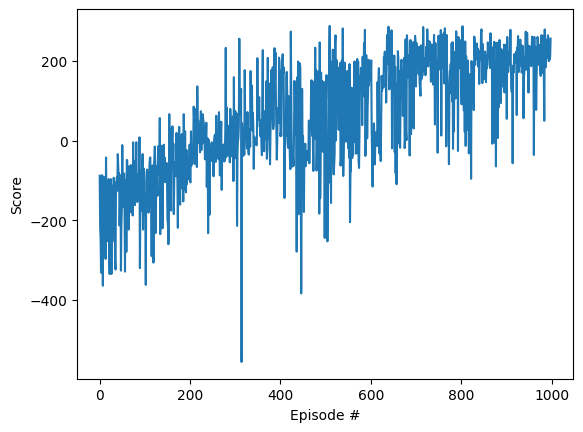

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
import gym
import glob
import io
import base64
from IPython.display import HTML


def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.act(state)

        state, reward, done, _ = env.step(action)
    env.close()


In [16]:
import os

# Create the 'video/' directory if it doesn't exist
if not os.path.exists('video'):
    os.makedirs('video')


In [17]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [20]:
import glob
import io
import base64
from IPython.display import display, HTML  # Import 'display' and 'HTML' from IPython.display

def show_video_1(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
        )
    else:
        print("Could not find video")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
show_video_1('LunarLander-v2')